In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pickle
%matplotlib inline

## Data load

In [2]:
with open('data.pkl', 'rb') as input:
    X_train = pickle.load(input)
    char_to_indexes = pickle.load(input)
    indexes_to_char = pickle.load(input)  
    data_size = pickle.load(input)
    vocab_size = pickle.load(input)  

In [ ]:
data = open('data.txt', 'r').read()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
char_to_indexes = { ch:i for i, ch in enumerate(chars) }
indexes_to_char = { i:ch for i, ch in enumerate(chars) }

X_train = np.zeros((data_size, vocab_size))
X_train[np.arange(data_size), 
        [char_to_indexes[char] for char in data]
       ] = 1

### hyperparameters

In [8]:
hidden_size = 100
seq_length = 25
learning_rate = 1e-1

## RNN

### Backward step computation for one timestep

I) $$ \frac{\partial (tanh(x))}{\partial (x)} = 1 - tanh^2(x)$$

II) $$ \frac{\partial (Ux_t + Ws_{t-1} + b)}{\partial (Ux_t)} = 1$$
$$ \frac{\partial (Ux_t + Ws_{t-1} + b)}{\partial (Ws_{t-1})} = 1$$
$$ \frac{\partial (Ux_t + Ws_{t-1} + b)}{\partial (b)} = 1$$


III.a) $$ \frac{\partial (Ws_{t-1})}{\partial (W)} = s_{t-1}$$
$$ \frac{\partial (Ws_{t-1})}{\partial (s_{t-1})} = W$$

III.b) $$ \frac{\partial (Ux_t)}{\partial (U)} = x_t$$
$$ \frac{\partial (Ux_t)}{\partial (x_t)} = U$$


In [24]:
def cross_entropy(x, y):
    '''
    x: input in a one hot encoding
    y: index encoding
    '''
    return -np.log(x[y, 0])

def cross_entropy_derivative(y_predicted, y):
    '''
    y_predicted: input in a one hot encoding
    y: index encoding
    '''
    y_predicted[y] -= 1
    return y_predicted

def softmax(x):
    exps = np.exp(x)
    return exps / np.sum(exps)


In [31]:
class RNN():
    def __init__(self, vocab_size,
                 loss_function=cross_entropy, loss_function_derivative=cross_entropy_derivative,
                 activation_function=np.tanh,
                 hidden_size=100, seq_length = 25, learning_rate = 1e-1):
        
        _variace = 0.01
        self.U = np.random.randn(hidden_size, vocab_size) * _variace # to input
        self.W = np.random.randn(hidden_size, hidden_size) * _variace # to recurrent
        self.V = np.random.randn(vocab_size, hidden_size) * _variace # to output

        self.b_s = np.zeros((hidden_size, 1)) # hidden bias
        self.b_y = np.zeros((vocab_size, 1)) # output bias
        
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative
        self.activation_function = activation_function
        
        
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.s = {}
        self.state_gradients = {}
        self.input_gradients = {}
        self.recurrent_gradients = {}
        
    @property
    def params(self):
        return {'U':self.U, 'W':self.W, 'V':self.V, 'b_s':self.b_s, 'b_y':self.b_y}
        
    def _step_forward(self, x, prev_s):
        next_s = self.activation_function(np.dot(self.U, x.reshape((-1, 1))) +
                                          np.dot(self.W, prev_s) + 
                                          self.b_s)
        y_predicted = np.dot(self.V, next_s) + self.b_y
        probability_predicted = softmax(y_predicted)
        return next_s, y_predicted, probability_predicted
    
    def forward(self, x, y, s_initial=None):
        '''
        x: input in a one hot encoding sentence
        y: index encoding sentence
        '''
        y_predicted, probability_predicted = {}, {}
        if s_initial is not None:
            self.s[-1] = np.copy(s_initial)
        else:
            self.s[-1] = np.zeros((self.hidden_size, 1))
        loss = 0
        for t in range(len(x)):
            self.s[t], y_predicted[t], probability_predicted[t] = self._step_forward(x[t], self.s[t - 1])
            loss += self.loss_function(probability_predicted[t], y[t])
        return loss, self.s, y_predicted, probability_predicted 
    
    def backpropagate_loss(self, probability_predicted, x, y):
        '''
        probability_predicted: it comes from the forward pass
        x: input in a one hot encoding sentence
        y: index encoding sentence
        '''
        dU, dW, dV = np.zeros_like(self.U), np.zeros_like(self.W), np.zeros_like(self.V)
        db_s, db_y = np.zeros_like(self.b_s), np.zeros_like(self.b_y)
        ds_previous_time = np.zeros_like(self.s[0])
        for t in reversed(range(len(x))):
            # propagate gradients
            probability_predicted_at_t = np.copy(probability_predicted[t])
            d_loss = self.loss_function_derivative(probability_predicted_at_t, y[t])
            # d(loss)/d(V) = (d(sigmoid(Vs))/d(Vs)) * (d(Vs)/dV) = (d(sigmoid(Vs))/d(Vs)) * s
            dV += np.dot(d_loss, self.s[t].T)
            # d(loss)/d(bias) = (d(sigmoid(Vs))/d(Vs)) * (d(Vs + b)/db) = (d(sigmoid(Vs))/d(Vs)) * 1            
            db_y += d_loss
            # d(loss)/d(s) = (d(sigmoid(Vs + b))/d(Vs + b)) * (d(Vs + b)/ds) = (d(sigmoid(Vs))/d(Vs)) * V
            ds = np.dot(self.V.T, d_loss) + ds_previous_time
            # d(s)/d(Ws_t-1 + Ux + b) = d(tanh(Ws_t-1 + Ux + b))/d(Ws_t-1 + Ux + b) = (1 - (tanh^2(Ws_t-1 + Ux + b))) * ds
            dsum = (1 - self.s[t] * self.s[t]) * ds
            # d(s)/d(Ws_t-1 + Ux + b) = d(tanh(Ws_t-1 + Ux + b))/d(b) = (1 - (tanh^2(Ws_t-1 + Ux + b))) * 1
            db_s += dsum
            
            # d(sum)/d(U) = d(Ws_t-1 + Ux + b)/dU = x.   => dU = d(next_layer)/dU  * d(next_layer_output)            
            dU += np.dot(dsum, x[t].reshape((1, -1)))
            dW += np.dot(dsum, self.s[t - 1].T)
            ds_previous_time = np.dot(self.W.T, dsum) 
            
            self.state_gradients[t] = ds_previous_time
            self.input_gradients[t] = np.sum(np.square(dU), axis=1)
            self.recurrent_gradients[t] = np.sum(np.square(dW), axis=1)
        
        for param in [dU, dW, dV, db_s, db_y]:
            np.clip(param, -5, 5, out=param)
            
        return dU, dW, dV, db_s, db_y
    
    def sample(self, seed, n):
        '''
        seed: index of first char
        n: number of chars to sample
        '''
        char_one_hot = np.zeros((self.vocab_size, 1))
        char_one_hot[seed] = 1
        chars = []
        state = np.zeros((self.hidden_size, 1))
        for t in range(n):
            state, y_predicted, probability_predicted = self._step_forward(char_one_hot, state)
            index = np.random.choice(range(vocab_size), p=probability_predicted.ravel())
            chars.append(indexes_to_char[index])
            char_one_hot = np.zeros((self.vocab_size, 1))
            char_one_hot[index]
            
        txt = ''.join(chars)
        print(txt)
        
    def set_parameters(self, param_dict):
        self.U = param_dict['U']
        self.W = param_dict['W']
        self.V = param_dict['V']
        self.b_s = param_dict['b_s']
        self.b_y = param_dict['b_y']
        

In [32]:
rnn = RNN(vocab_size)

### Train generator


In [33]:
def train_data_generator(data, step=1, chunk_size=10, one_hot_targets=False):
    if step > len(data):
        raise ValueError
    data_pointer = 0
    while data_pointer + chunk_size < len(data) - 1:
        x_train_batch = data[data_pointer:data_pointer + chunk_size]
        y_train_batch = data[data_pointer + 1:data_pointer + chunk_size + 1]
        data_pointer += step
        if not one_hot_targets:
            y_train_batch = list(np.argmax(y_train_batch, axis=1))
        
        yield x_train_batch, y_train_batch

### Optimizer

In [34]:
class AdaGrad:
    def __init__(self, lr, params):
        self.learning_rate = lr
        self.params_to_optimize = {}
        self.old_G = {}
        for key, param in params.items():
            self.params_to_optimize[key] = param
            self.old_G[key] = np.zeros_like(param)
    
    def update(self, grad_params):
        if len(grad_params.keys()) is not len(self.params_to_optimize.keys()):
            raise ValueError
                    
        for key, param in grad_params.items():
            self.old_G[key] += grad_params[key] * grad_params[key]
            self.params_to_optimize[key] -= self.learning_rate * grad_params[key] / np.sqrt(self.old_G[key] + 1e-8)
            
        return self.params_to_optimize

In [35]:
adagrad = AdaGrad(learning_rate, rnn.params)

### plot of gradient over time

In [41]:
def plot_gradient_over_time(grad_dict):
    grad_over_time = [np.sum(np.square(grad_at_t)) for key, grad_at_t in grad_dict.items()] 
    x = np.arange(-seq_length + 1, 1, 1)
    plt.plot(x, grad_over_time)
    

### Train




  0%|          | 0/1 [00:00<?, ?it/s]

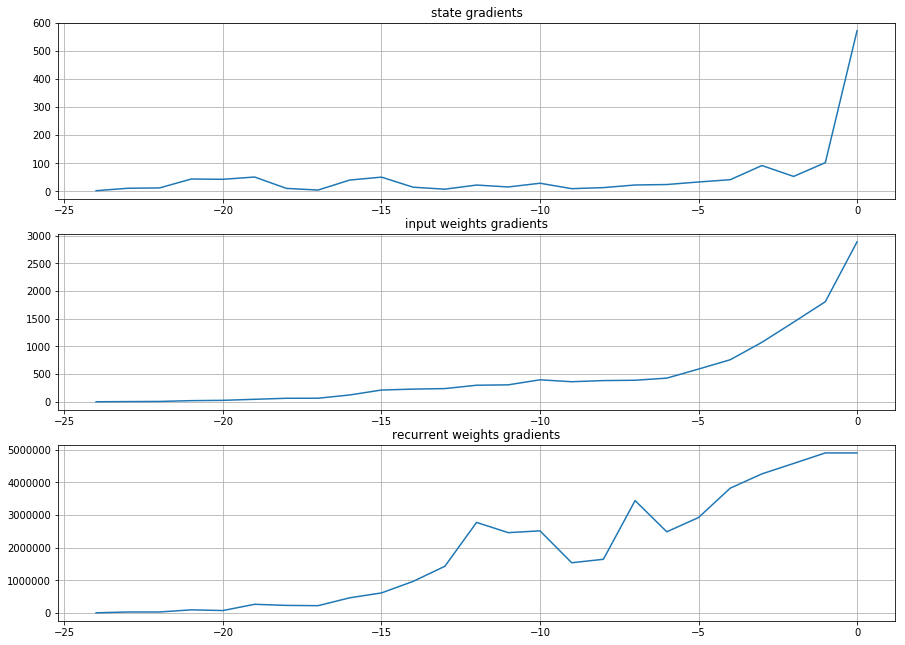

eont    ot neoao te e,   gmo,   t me mr,a,n l m  lm ema lo  orin l n     t   ,lenmgho aaa set,s m  ,
96.68582220110312


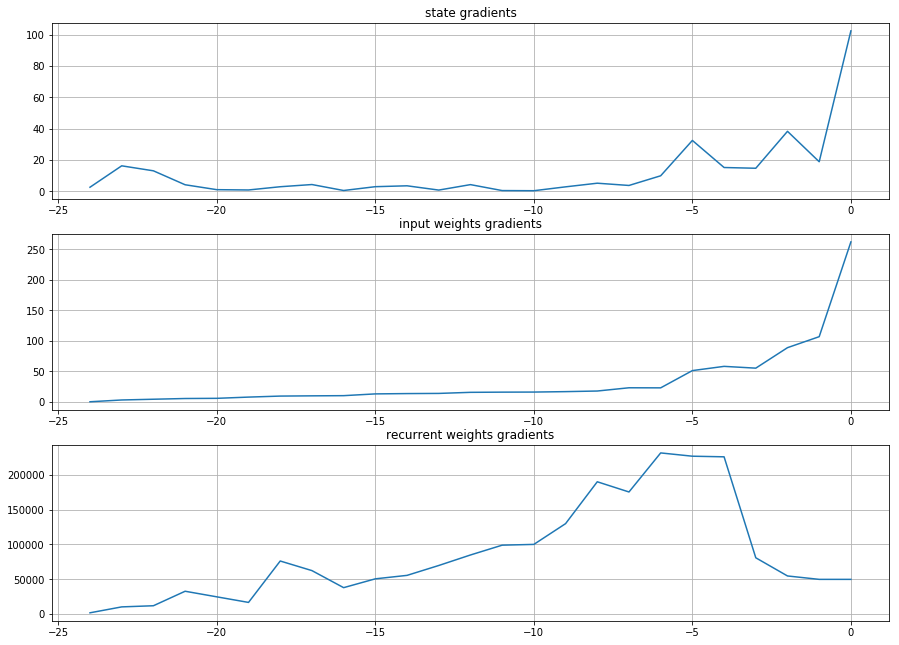

.
ooeeh
ariitero
rwe Geieeeoe i

hmrt
.i
.Gefhoreeaoeew
i.iiee
tt
.
roriGioeeeorGv
ve
iperh
reeehiwe
43.82653252202657


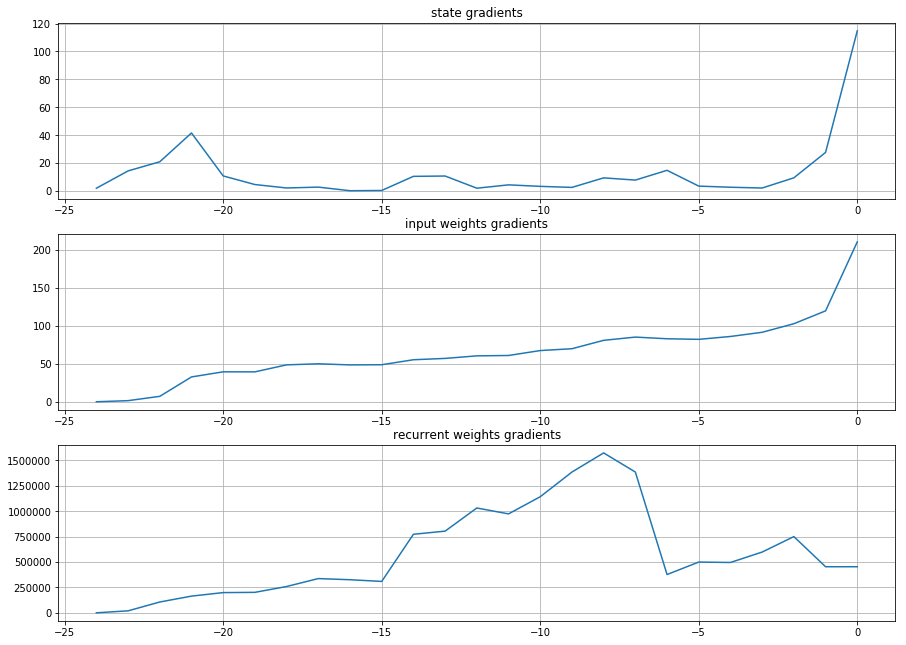

ettettltt tp pe tfffeegplftptptt,ieplpeplotpcpeol ttl lpiptetoletpt ttltrpp ttppeblatoeflfl nptel ld
46.001266588623785


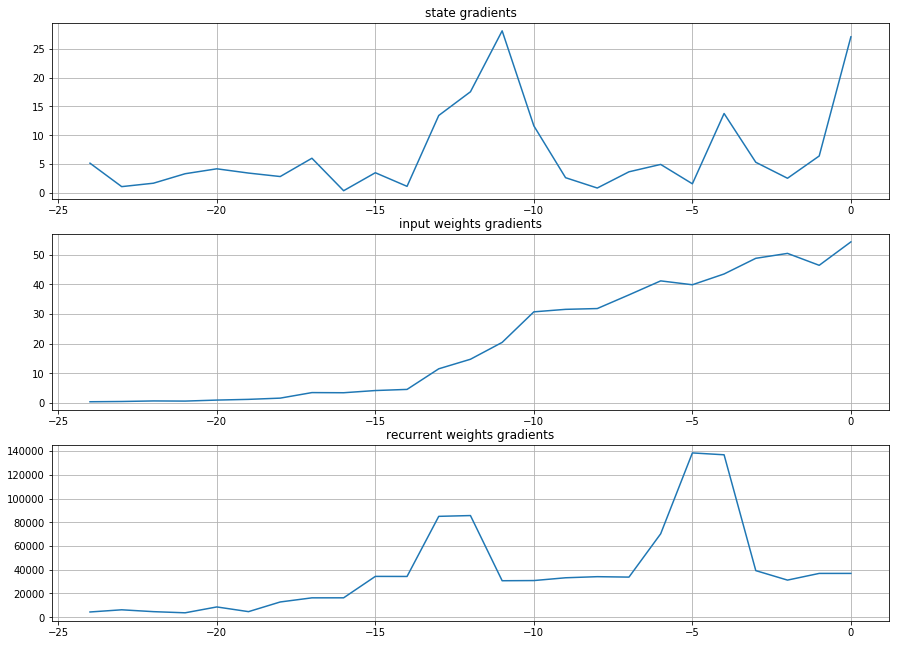

  ptrefoioeno onoohfffftffmmhtotbfenimeoife h ofederfte iretefe.itetiIegmmedi nffneninmfiffnftooemom
47.28232916091767


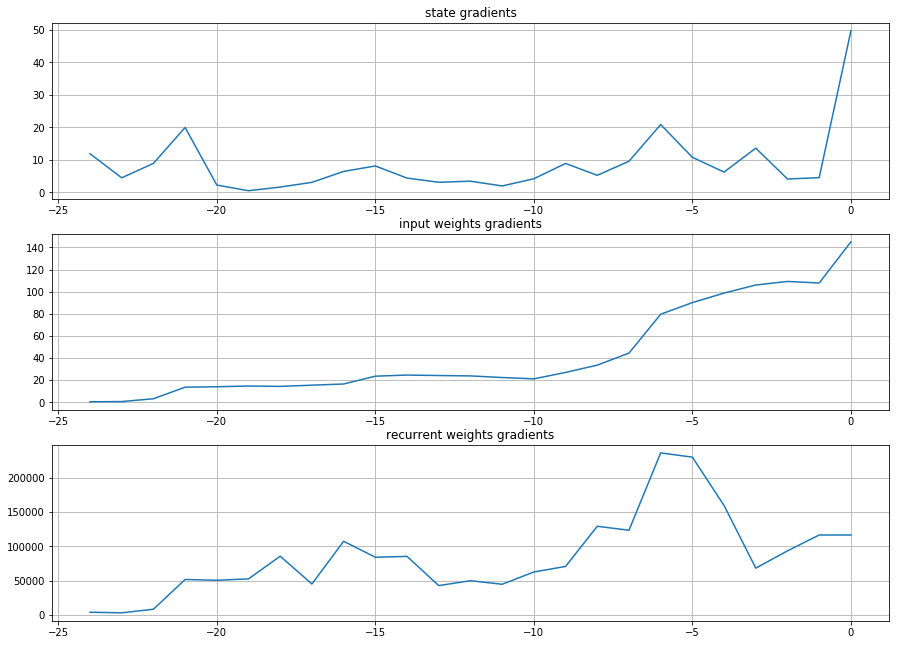

  e t t,eee   t l  ce h tuuurdto tttd   fmefeles fe sst e m e u a   t e e e t e e f eotttot   ese . 
46.43850752413824


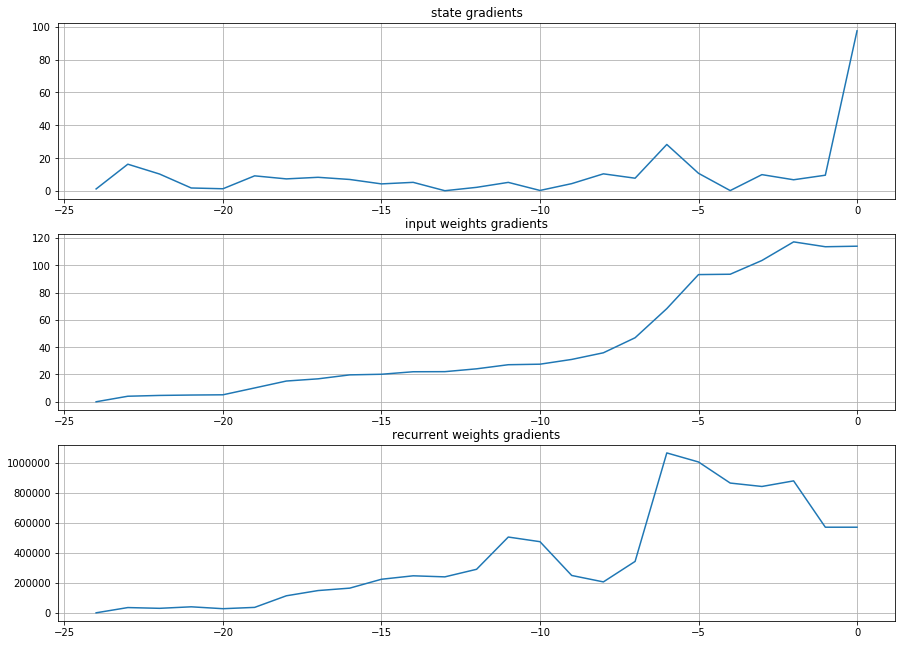

fbim tf tmd    mcdl   c   r tdmm     c c c s  t   d cmr    dtd   cdc  mm i d  tdc ry lf mnrs  c  rm 
50.21213024867842


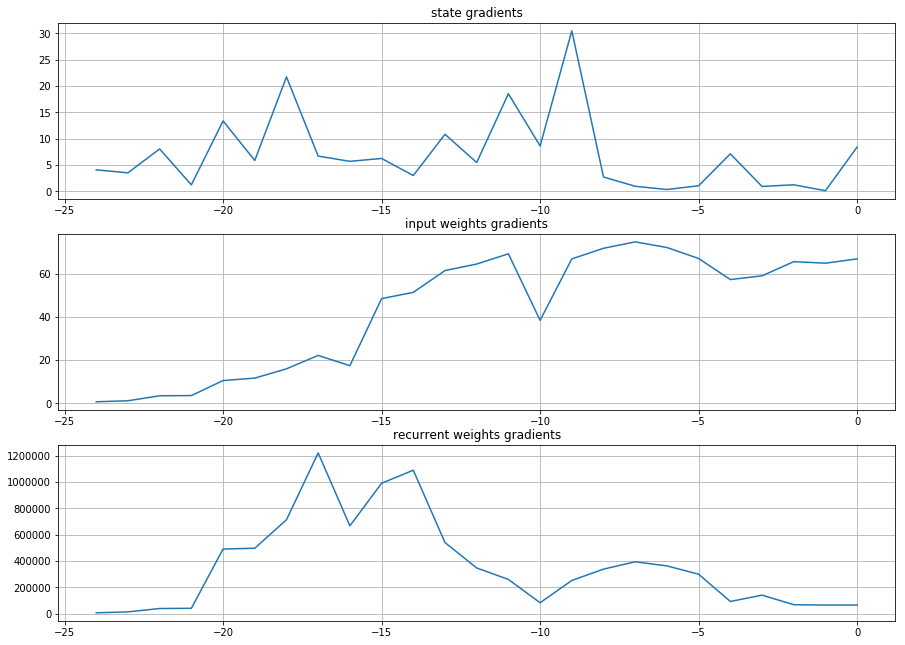

eu nr srensr c   e t  sref r  rss  w  w  b  fft  ew s e serss,  e  t  seer r, r  sf   r   t s   ns  
40.969257773123346


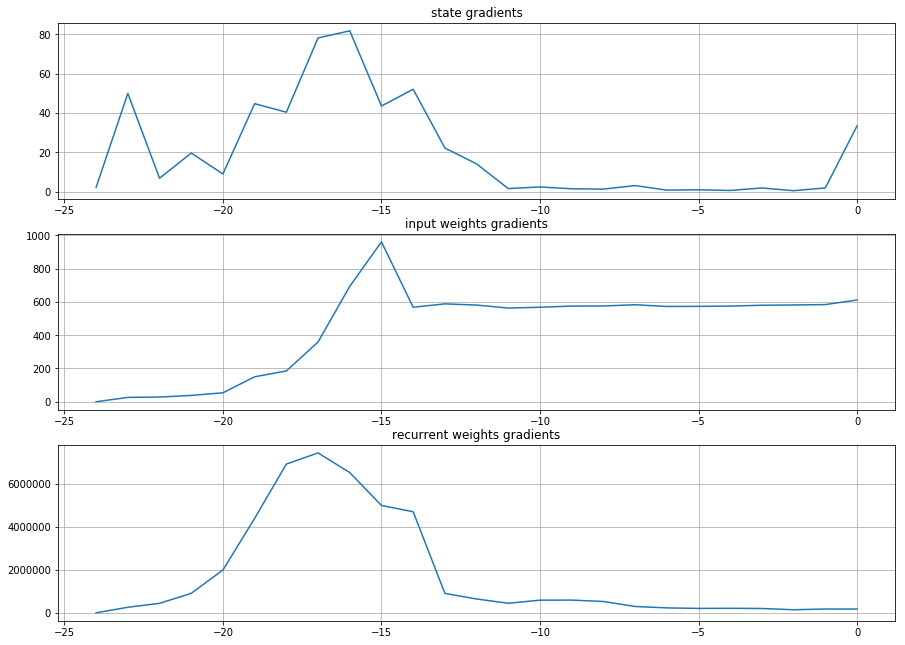

ovcioioiiisitohimicfhrsrfibiso oomiehunieikhsibmeohrei imico rrihmnoif ocoriaotitaeolohrhimo imiiiea
58.51776890464299


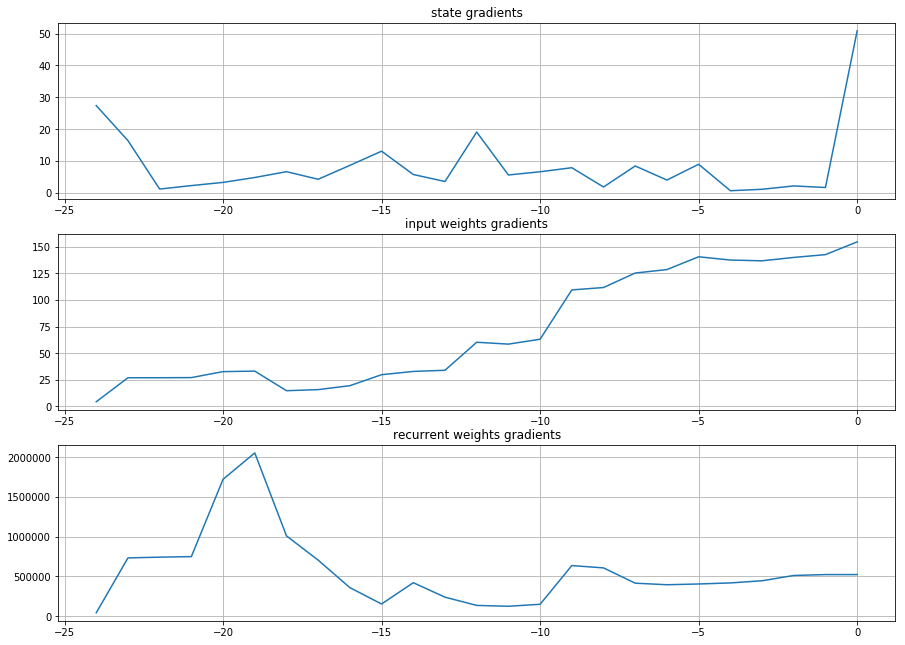

  tuesitsrsasooosrooofio aoroesertiftsrooiososstoiifairsaaforiosaitssseiiaoioieoeiftifoa offssooffos
65.33014896722311


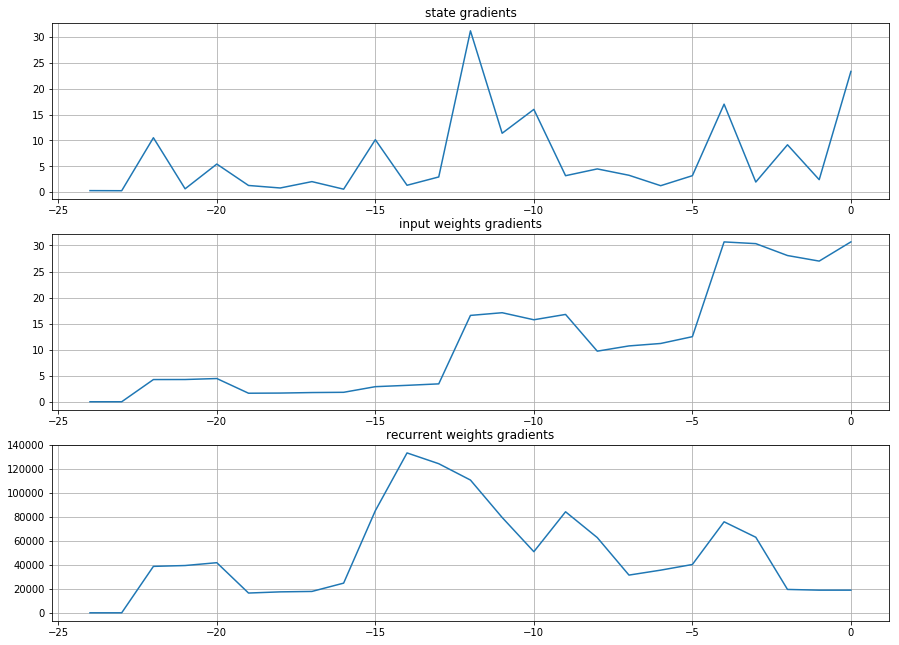

r  e oee   oeo eiekoo e oaao etehoouoioaooeo o ooohoeooeo oooo;eooioooaooe eereoeeoeoeooaoooooriroeo
37.45380673028739


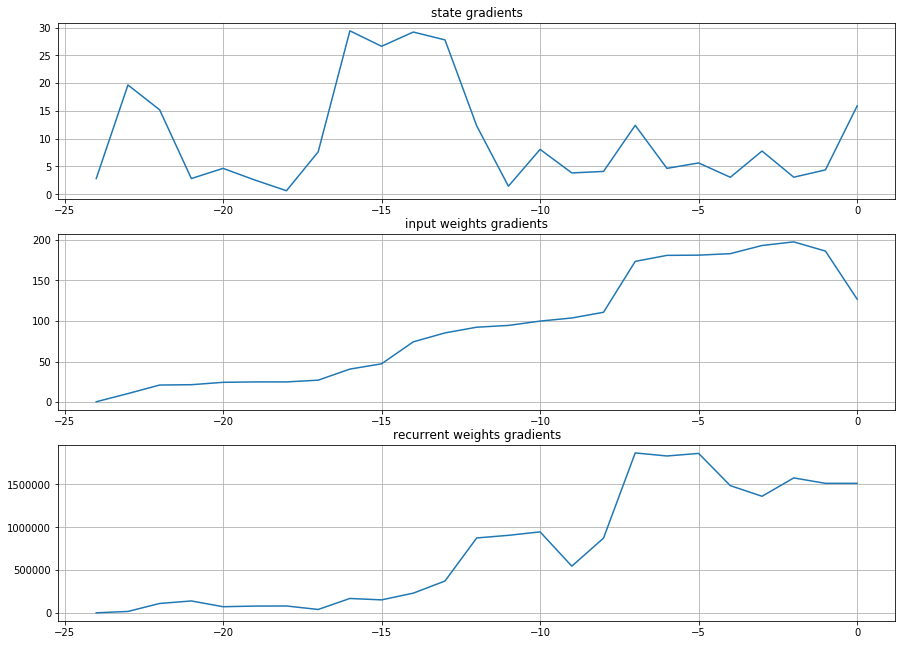

 nshe thebi reeto rlttesaareawreno ta tatee elfretretrhn  oeur mre drtwtearrlre tertoetn nkse reare 
55.79949585398829


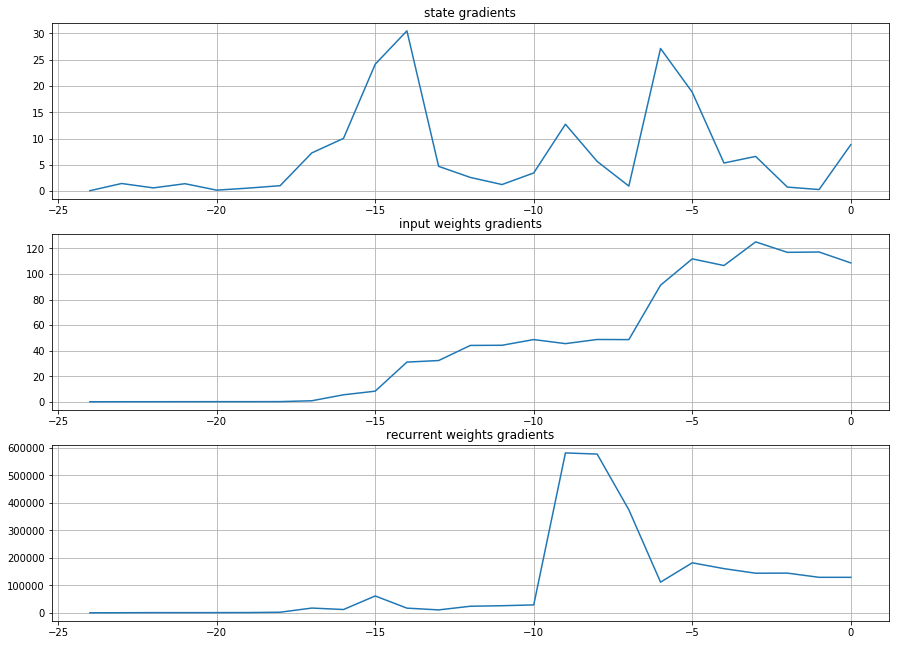

tseepiffoeleeaeieaehtapepeplehtppephpypeehprsxltpheiphpephpeeipashshphihpspasashseehpiphshehprpofrpi
44.79343464052483


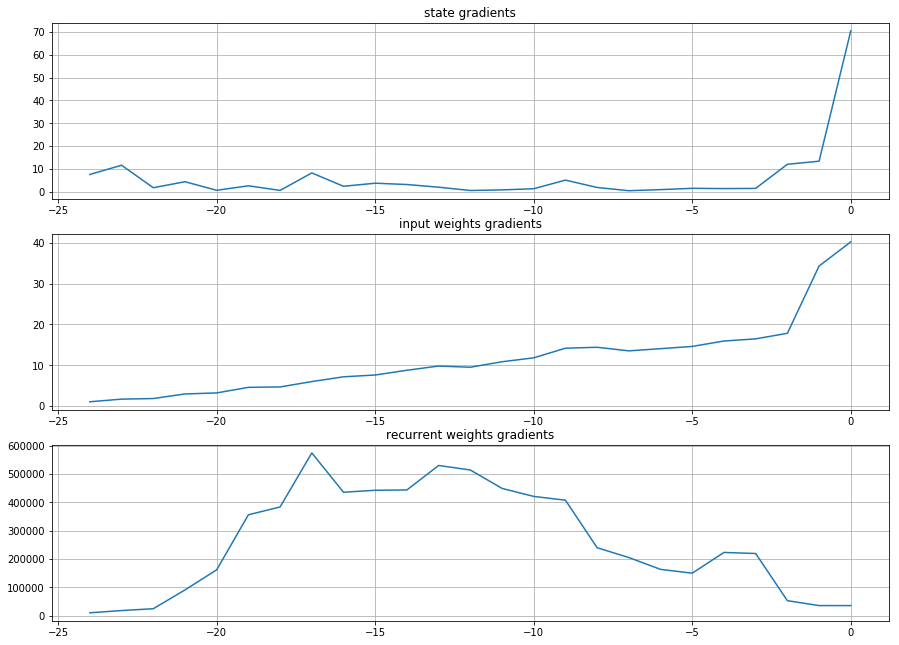

ka  t oet oaso o are oo   lo atiaa ra , d  aoraoaa ao aoato  s oerr    l aaooa e d loo   ooaorr ao o
35.590688013176894


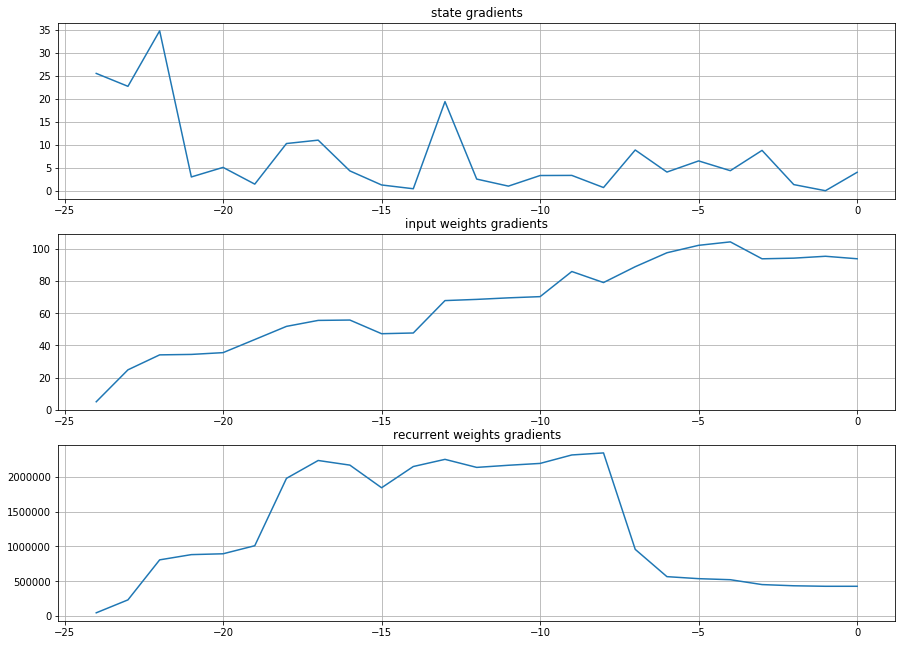

hoastozaeeiioeehhhteoaoaoeolatahaloahtihohaaemoteaoaoeeeiao aioeahuaeteaaeashaeeolaohheeieotolohhtea
38.47840904609171


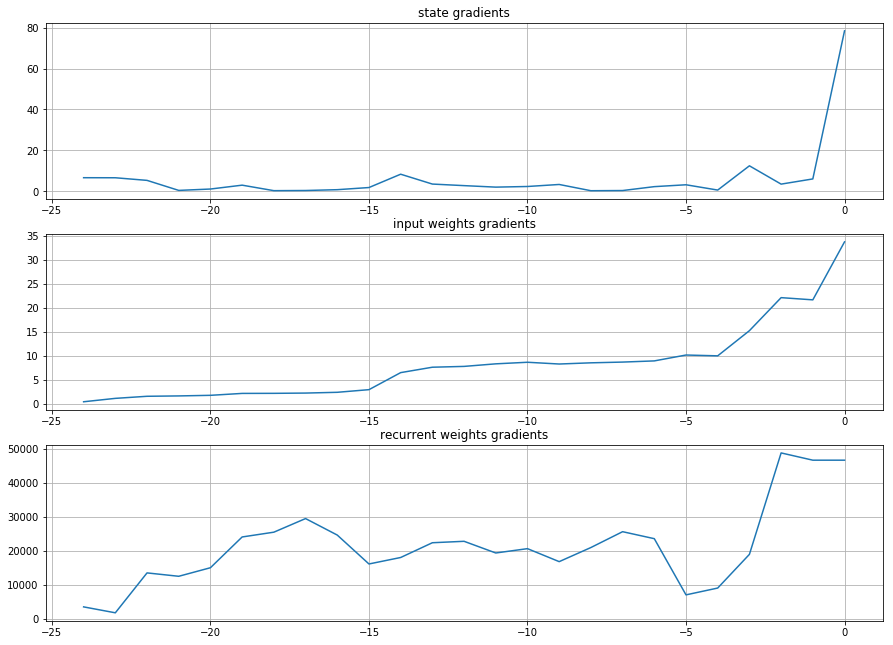

oaooin t oihai tioieic aitooit c o aooitilipiocasowaio oioopioia a iioo  hih iifioihih cipitiaipiiia
40.93879850416457


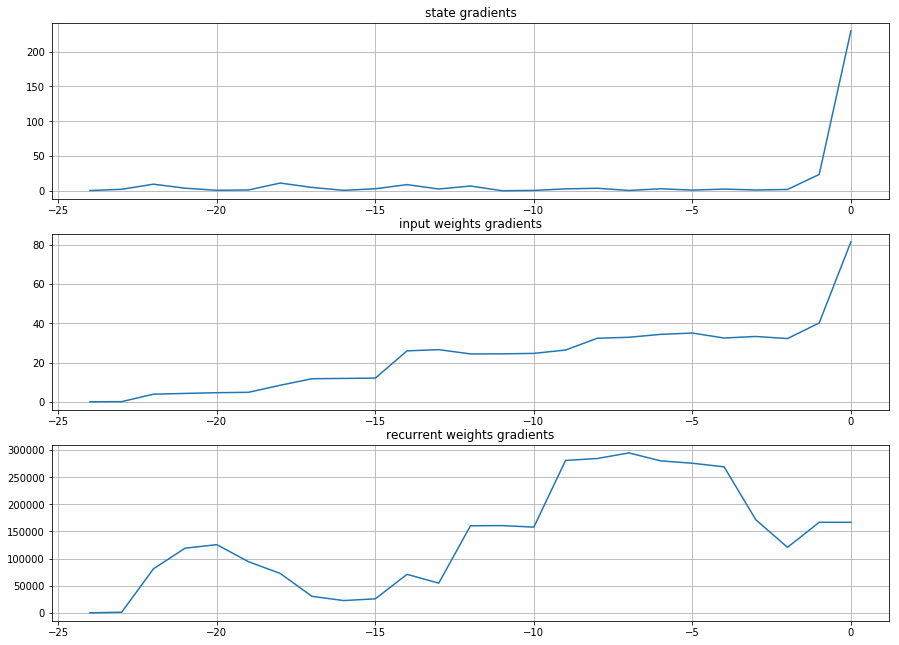

g '  s'     sg        g  g' dg''s    s g   g g 's'   , gg '         , ,s''g        '.g 
  ,    c    
41.725864658742935


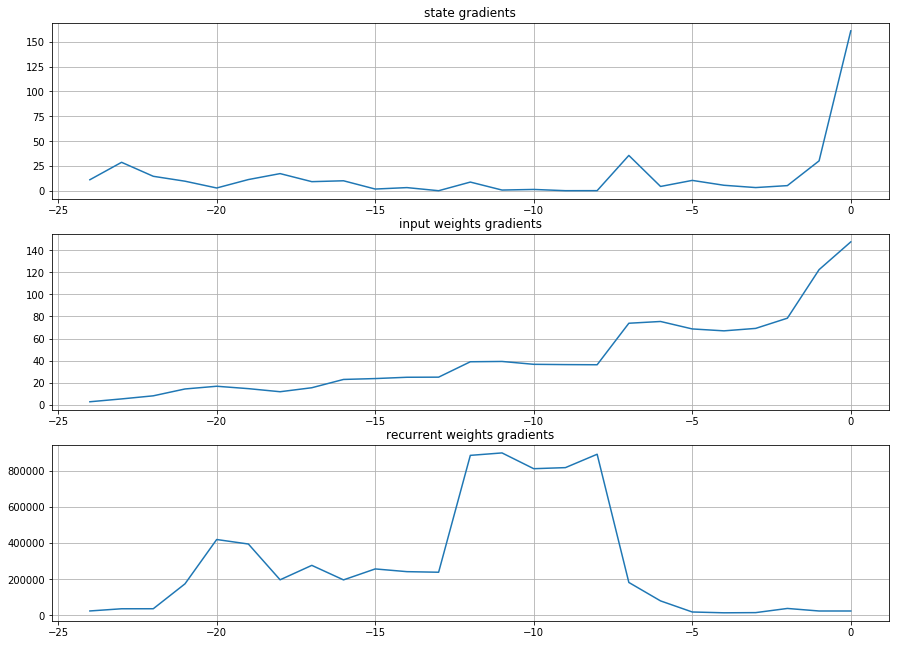

gprstttspaaraapeesaosaaaajrneaespaaaeaneeataartaeataetatajapeaeeearaeaaraeraeeeesatesaajtrareptaeaae
46.66390186424241


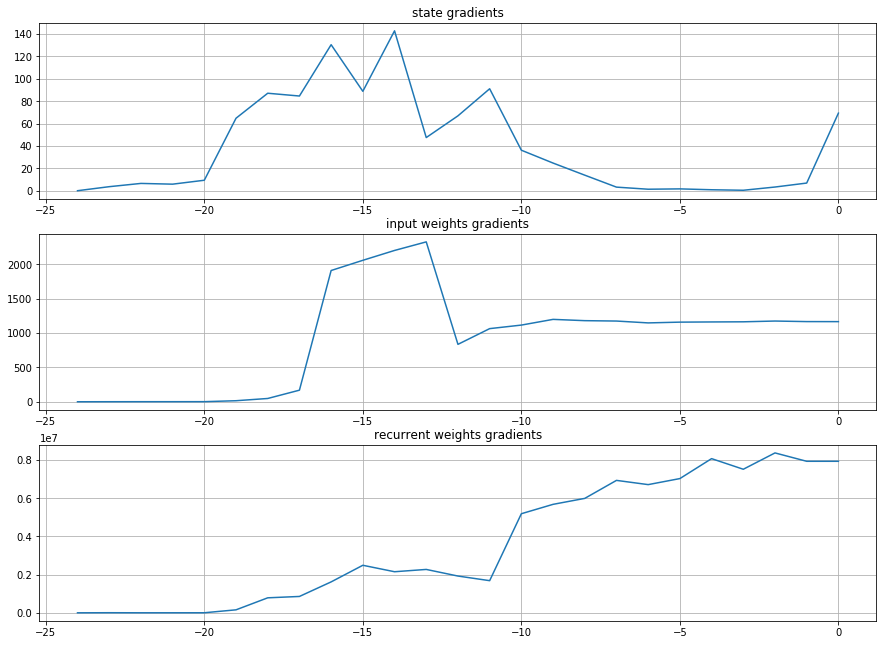

e s?whha,o"hy"thiiuhetedaecnyroa et"ewaakes,ityst"fi""ye etsew"a otkehih?ihi"eairiiieasu"euskuffkett
41.341328589797286


KeyboardInterrupt: 

In [45]:
n_epocs = 1
i = 0
losses = []
for epoc in tqdm(range(n_epocs)):
    for x_train, y_train in train_data_generator(X_train, step=1, chunk_size=seq_length):
        loss, history_state, y_predicted, probability_predicted = rnn.forward(x_train, y_train)
        dU, dW, dV, db_s, db_y = rnn.backpropagate_loss(probability_predicted, x_train, y_train)
        params = adagrad.update({'U':dU, 'W':dW, 'V':dV, 'b_s':db_s, 'b_y':db_y})
        rnn.set_parameters(params)
        
        if i % 1000 == 0:
            plt.figure(figsize=(15, 11))
            
            plt.subplot(311)
            plot_gradient_over_time(rnn.state_gradients)
            plt.title('state gradients')
            plt.grid(True)
            
            plt.subplot(312)
            plot_gradient_over_time(rnn.input_gradients)
            plt.title('input weights gradients')
            plt.grid(True)
            
            plt.subplot(313)
            plot_gradient_over_time(rnn.recurrent_gradients)
            plt.title('recurrent weights gradients')
            plt.grid(True)
            
            plt.show()
            rnn.sample(np.argmax(x_train[0]), 100)
            print(loss)
            losses.append(loss)
        i += 1
    n_epoc += 1

In [ ]:
plt.plot(losses)
plt.show()